# Adaptive simplification

The main feature of `neatnet` is the adaptive continuity-preserving simplification method aimed at automatised parameter-free conversion of input geometry to a morphological network. It is desgined to simplify large networks covering entire urban areas but is equally usable when dealing with smaller networks.

In [1]:
import matplotlib.pyplot as plt
import osmnx

import neatnet

Download a street network from OpenStreetMap using `osmnx` and represent it as a GeoDataFrame.

In [2]:
place = "Milton Keynes"
local_crs = 27700

We have picked Milton Keynes as it contains a considerable amount of cases that require simplification.

In [3]:
osm_graph = osmnx.graph_from_place(place, network_type="drive")
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osmnx.convert.to_undirected(osm_graph),
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True,
).reset_index(drop=True)

Check the current state of the network. If you are running the notebook locally, you can use `streets.explore()` for interactive visualisation.

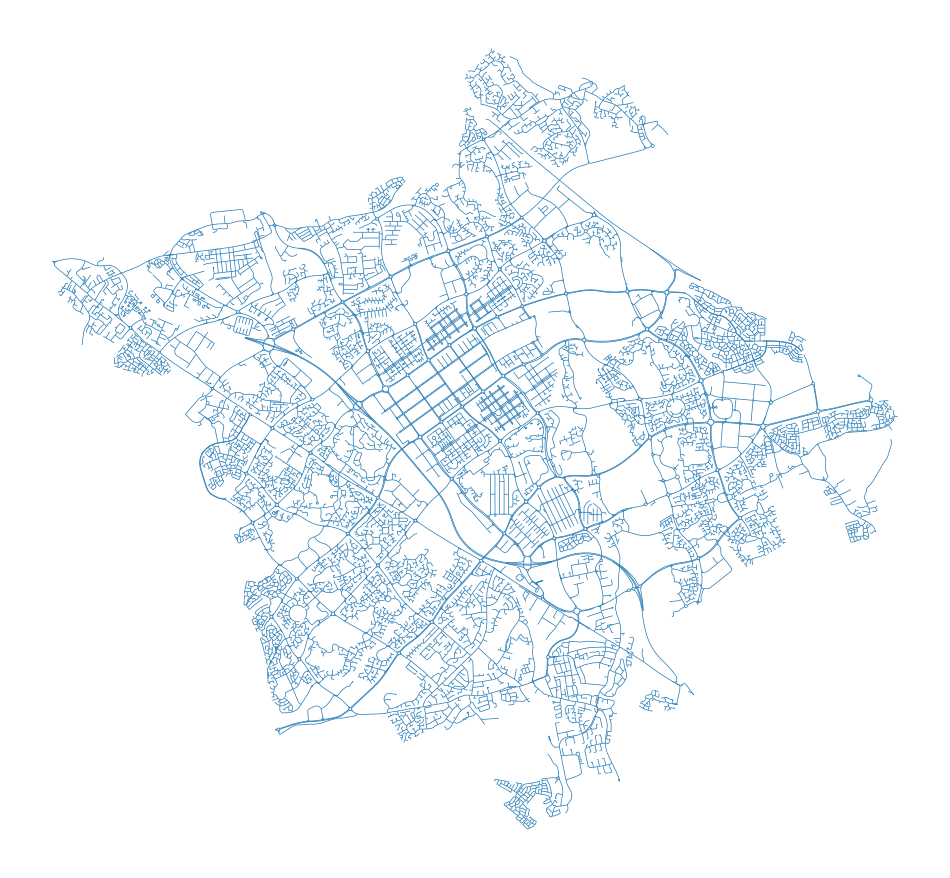

In [4]:
ax = streets.plot(figsize=(12, 12), linewidth=0.5)
ax.set_axis_off()

You can also zoom in to the city centre which is a clear case requiring simplification.

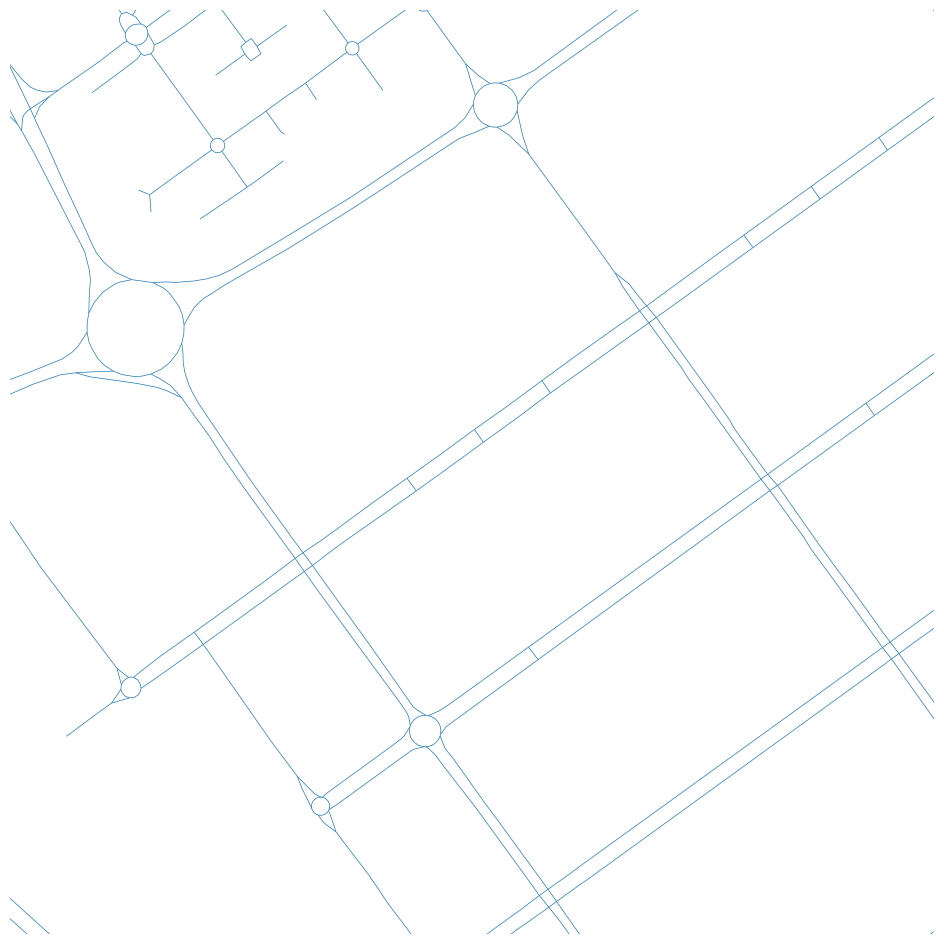

In [5]:
city_centre = (484500, 238500)

ax = streets.plot(figsize=(12, 12), linewidth=0.5)
ax.set_xlim(city_centre[0] - 500, city_centre[0] + 500)
ax.set_ylim(city_centre[1] - 500, city_centre[1] + 500)
ax.set_axis_off()

The algorithm implemented in `neatnet.neatify` should be able to resolve all the issues above, mostly without using any parameters as the detection of locations of change is adaptively derived from the network itself. However, if you have access to building footprints, it is recommended to use those as an "exclusion mask", marking areas enclosed by the street network that shall be preserved without a change. In some cases, some smaller or narrower blocks may be mislabeled as artifacts. Passing in an exclusion mask prevents that.

In [6]:
buildings = (
    osmnx.features_from_place(place, tags={"building": True})
    .query('building != "roof"')
    .to_crs(streets.crs)
)

This may take a minute or so.

In [7]:
simplified = neatnet.neatify(streets, exclusion_mask=buildings.geometry)

Let's check what has happened in the city centre.

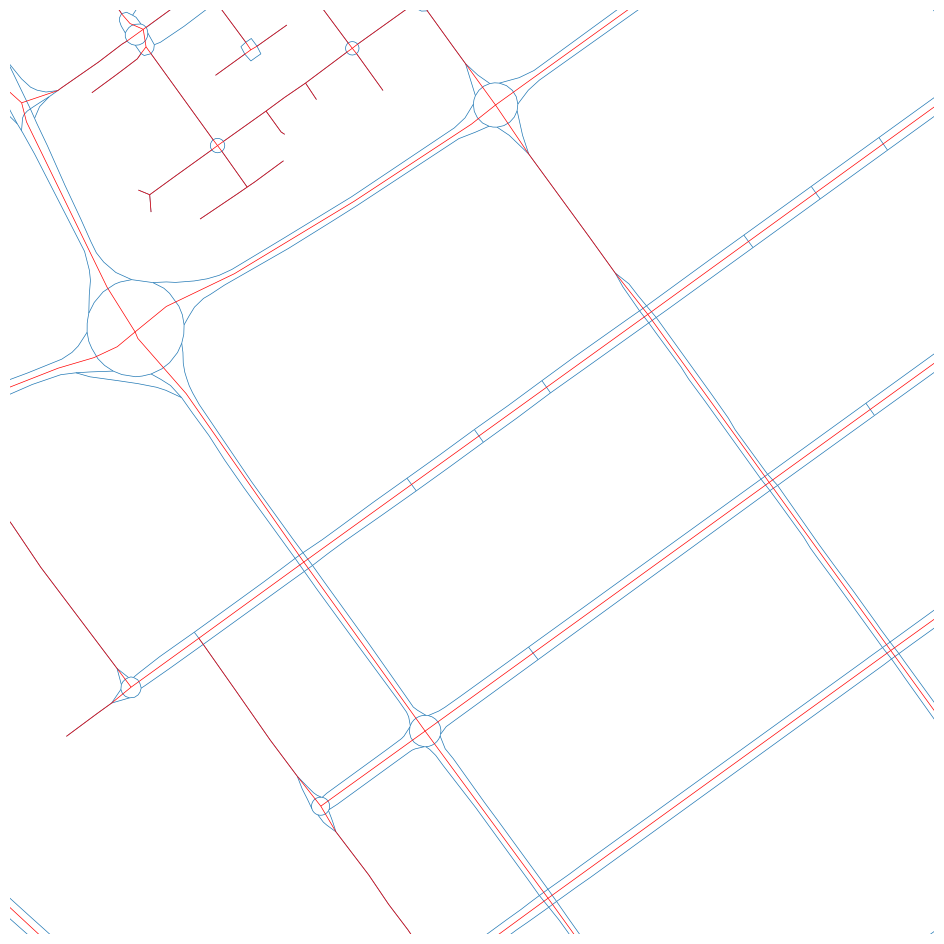

In [8]:
ax = streets.plot(figsize=(12, 12), linewidth=0.5)
simplified.plot(color="red", linewidth=0.5, ax=ax)
ax.set_xlim(city_centre[0] - 500, city_centre[0] + 500)
ax.set_ylim(city_centre[1] - 500, city_centre[1] + 500)
ax.set_axis_off()

In blue, you can see the original network and in red the simplified one. As is clearly shown, all dual carriegaways are collapsed to a sinlge line, roundabouts are represented by a sinlgle node, and complex intersections likewise. 

This comparison is easier to see side-by-side.

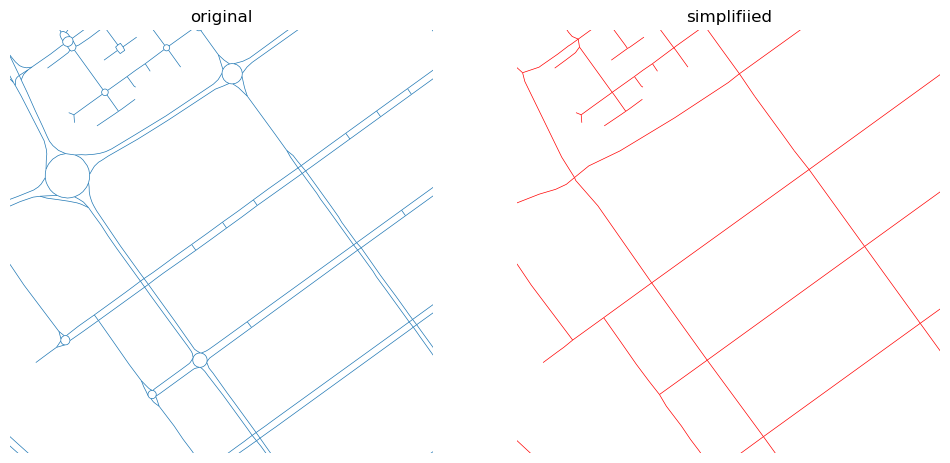

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 7))

streets.plot(ax=axs[0], linewidth=0.5)
simplified.plot(color="red", linewidth=0.5, ax=axs[1])
for ax in axs:
    ax.set_xlim(city_centre[0] - 500, city_centre[0] + 500)
    ax.set_ylim(city_centre[1] - 500, city_centre[1] + 500)
    ax.set_axis_off()
axs[0].set_title("original")
axs[1].set_title("simplifiied");

The resulting data frame also contains information about the status of each geometry, whether it has been changed or is completely new.

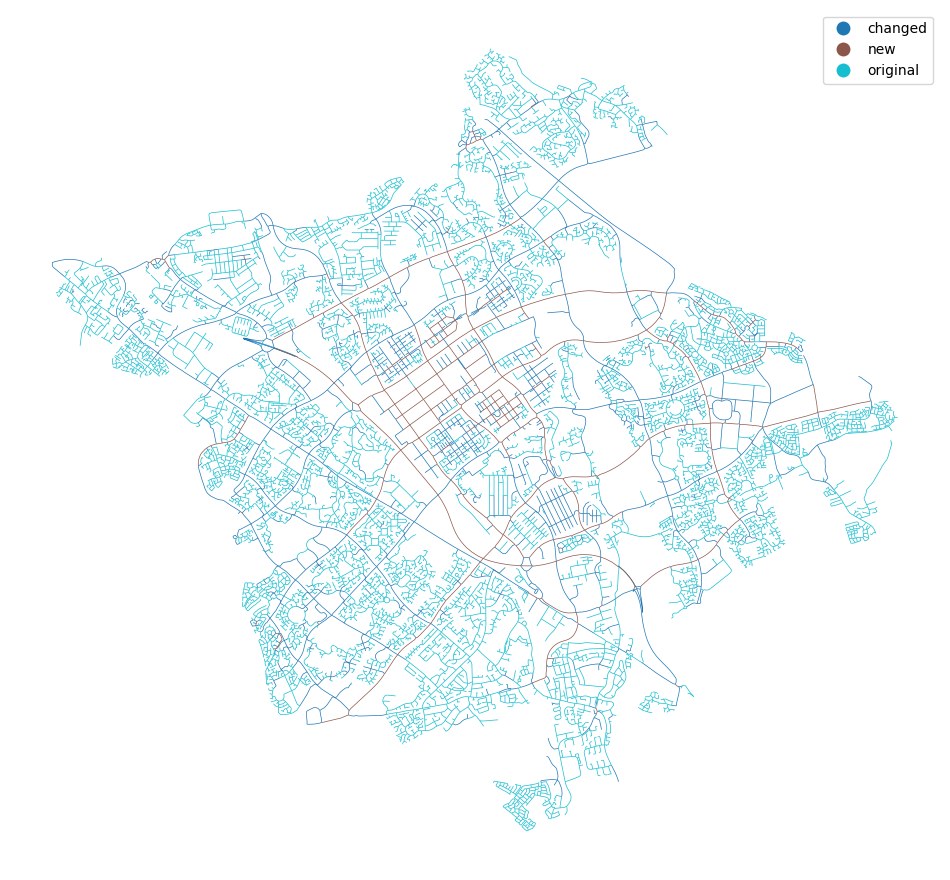

In [10]:
ax = simplified.plot("_status", figsize=(12, 12), linewidth=0.5, legend=True)
ax.set_axis_off()

The attributes from the original network are preserved, but keep in mind that they may no longer be valid for `changed` geometries.

The function allows passing in a wide range of additional parameters if you need to fine tune the result. However, in most cases the default values are sufficient. Just keep in mind that they assume a projected CRS in meters.